In [1]:
import pandas as pd
import numpy as np
import re, os

from sklearn.linear_model import LinearRegression

%matplotlib inline

import matplotlib.pyplot as plt

data_path = "/mnt/c/users/geneb/documents/USC/work/casden"

# Use Co-Star Data to Make Predictions

Data were pre-processed in the Co-Star Data Prep and Check notebook. Beside a few extra variables, the data contain a consolidation of sub-markets that somewhat aligns with Co-Star data

# Load Data

In [2]:
df = pd.read_csv("/".join([data_path, 'costart_prepped.csv']))

# Process Data

In [3]:
# Clean up columns (need to remove / and % and the like)
df.columns = df.columns.str.replace("%|/| ",'_').str.lower()

In [4]:
# rename a few columns for convenience
df.rename(columns = {'market_asking_rent_unit':'rent_t','absorption__':'abs_t','vacancy_rate':'vr_t',"net_delivered_units":'net_dlvr_t',"under_construction_units":'cnstr_t',"gross_delivered_units":'g_dlvr_t'},inplace=True)

In [5]:
# Create necessary lags in rent, vacancy, abs, etc(demographics later)
## Note, need to shift within submarkets hence groupby
toshift = ['rent_t','abs_t','vr_t','net_dlvr_t','cnstr_t','g_dlvr_t']
shftd = df.groupby('geography_name')[toshift].shift(1)

In [6]:
# rename columns with t-1 or something like it
shftd.columns = shftd.columns.str.replace("t$",'t1')

In [7]:
# combine with main dataset
df = pd.concat([df,shftd],axis=1)

In [8]:
# check results
sub = df.geography_name.str.contains('Culver City')
df.loc[sub,['year','period','rent_t','rent_t1']]

,year,period,rent_t,rent_t1
3995,2000,2000 Q1,1483.209595,NaN
3996,2000,2000 Q2,1512.933594,1483.209595
3997,2000,2000 Q3,1540.532837,1512.933594
3998,2000,2000 Q4,1570.116699,1540.532837
3999,2001,2001 Q1,1609.699951,1570.116699
...,...,...,...,...
4075,2020,2020 Q1,2471.695801,2478.141602
4076,2020,2020 Q2,2418.233643,2471.695801
4077,2020,2020 Q3,2378.078857,2418.233643
4078,2020,2020 Q4,2376.016113,2378.078857


In [9]:
# extract quarters
df.loc[:,'quarter'] = df.period.str[-2:].str.strip()

# Filter down to markets of interest

Seems I downloaded all of CA

In [10]:
intrs = ['Los Angeles','Orange','San Diego','Ventura','Inland Empire']
df = df.loc[df.market.str.contains("|".join(intrs)),:]

# Make dummy for each market and quarter

In [11]:
# make dummies and combine with main data set
df = pd.concat([df,pd.get_dummies(df.market)],axis=1)

In [12]:
df = pd.concat([df,pd.get_dummies(df.quarter)],axis=1)

# Predictions

In [13]:
# load the sklearn packages
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics

## Divide into training and test sets

In [14]:
# leave 2019 onward as the test set
splityear = 2019
train = df.loc[df.year<splityear].dropna(how='any')
test = df.loc[df.year>=splityear].dropna(how='any')

In [15]:
culver_tr = train.geography_name.str.contains("Culver City")
culver_test = test.geography_name.str.contains("Culver City")


## Fit the reg models

In [16]:
# make container for linear models
lrd = {}

# dictionary for covariates
Xd = {}

In [17]:
df.columns

Index(['property_class_name', 'period', 'slice', 'as_of', 'geography_name',
       'property_type', 'geography_code', 'forecast_scenario', 'cbsa_code',
       'geography_type', 'abs_t', 'absorption_units', 'absorption_units_12_mo',
       'asset_value', 'average_sale_price', 'average_units_sold', 'cap_rate',
       'cap_rate_transactions', 'demand_units', 'demolished_units',
       'existing_buildings', 'gross_delivered_buildings', 'g_dlvr_t',
       'inventory_units', 'market_asking_rent_growth',
       'market_asking_rent_growth_12_mo', 'market_asking_rent_index',
       'market_asking_rent_sf', 'rent_t', 'market_cap_rate',
       'market_effective_rent_growth', 'market_effective_rent_growth_12_mo',
       'market_effective_rent_sf', 'market_effective_rent_unit',
       'market_sale_price_growth', 'market_sale_price_per_unit',
       'median_cap_rate', 'median_price_bldg_sf', 'median_price_unit',
       'net_dlvr_t', 'net_delivered_units_12_mo', 'occupancy_rate',
       'sales_volume

### Fit rents

In [18]:
Xd['rent'] = ['vr_t1','rent_t1','Orange County','San Diego','Ventura','Inland Empire','Q2','Q3','Q4']
y = ['rent_t']

# set the model
lrd['rent'] = LinearRegression()

# fit the model
lrd['rent'].fit(train.loc[:,Xd['rent']],train.loc[:,y])

# make predictions on test set
test.loc[:,'preds']  = lrd['rent'].predict(test.loc[:,Xd['rent']])
#test.loc[:,'preds'] = test.preds.shift(-1)

#mse = metrics.mean_squared_error(test.loc[:,y])
cond = test.notnull().all(axis=1)
mae = metrics.mean_absolute_error(test.loc[cond,y], test.loc[cond,'preds'])
print("Mean Abs Error {}".format(mae))

n = test.shape[0]
pre = np.divide(test.loc[cond,['rent_t','preds']].diff(axis=1).iloc[:,1],test.loc[cond,'rent_t']).mean()
print("Mean average percent error %.3f" %pre)

#plot real vs predicted
#test.loc[culver_test,['period','rent_t','preds']].set_index('period').plot()

Mean Abs Error 13.75668577338717
Mean average percent error 0.002


### Fit Vacancies

In [19]:
Xd['vr'] = ['vr_t1','cnstr_t1','Orange County','San Diego','Ventura','Inland Empire','Q2','Q3','Q4'] #,'abs_t1'
y = 'vr_t'

# set the model
lrd['vr'] = LinearRegression()

# fit the model
lrd['vr'] .fit(train.loc[:,Xd['vr']],train.loc[:,y])

# make predictions on test set
test.loc[:,'preds_vr']  = lrd['vr'] .predict(test.loc[:,Xd['vr']]).flatten()

n = test.shape[0]
pre = np.divide(test.loc[:,[y,'preds_vr']].diff(axis=1).iloc[:,1],test.loc[:,y]).mean()
print("Mean average percent error %.3f" %pre)

Mean average percent error 0.028


### Fit Construction

In [20]:
Xd['cnstr'] = ['rent_t1','vr_t1','cnstr_t1','Orange County','San Diego','Ventura','Inland Empire','Q2','Q3','Q4']
y = 'cnstr_t'

# set the model
lrd['cnstr'] = LinearRegression()

# fit the model
lrd['cnstr'].fit(train.loc[:,Xd['cnstr']],train.loc[:,y])

# make predictions on test set
test.loc[:,'preds_cnstr']  = lrd['cnstr'].predict(test.loc[:,Xd['cnstr']]).flatten()

#n = test.shape[0]
#pre = np.divide(test.loc[:,[y,'preds_cnstr']].diff(axis=1).iloc[:,1],test.loc[:,y]).mean()
#print("Mean average percent error %.3f" %pre)

mae = metrics.mean_absolute_error(test.loc[:,y], test.loc[:,'preds_cnstr'])
print("Mean Abs Error {}".format(mae))

Mean Abs Error 113.06478111228205


<AxesSubplot:xlabel='period'>

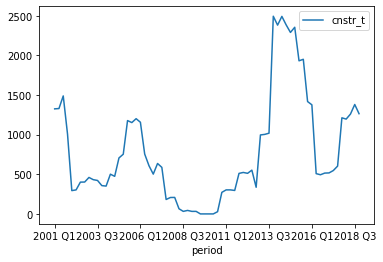

In [21]:
train.loc[train.geography_name.str.contains("Culver City"),['period','cnstr_t']].set_index('period').plot()

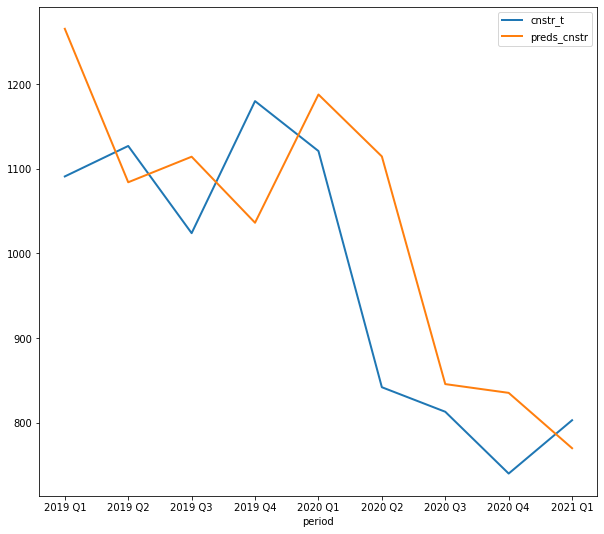

In [22]:
test.loc[test.geography_name.str.contains("Culver City"),['period','cnstr_t','preds_cnstr']].set_index('period').plot(figsize = (10,9),linewidth = 2)
plt.savefig("/".join([data_path, 'culver_city_construction_preds.png']))

# Make Test Predictions

Goal is to go 1 quarter at a time forward in each of the variables and itirate until we make all of the predictions

In [23]:
# for convenience, I include the test-splitting here
test = df.loc[df.year>=splityear].dropna(how='any')

In [24]:
# get a list of periods to predict
predPeriods = test.period.unique()

In [25]:
# initiate containers
predDict = {}
dataDict = {}

In [26]:
# initial conditions
init = test.loc[test.period == predPeriods[0],:].set_index("geography_name")
initIdx = init.index
# keep a copy of the market dummies
dums = init[['Orange County','San Diego','Ventura','Inland Empire','Q2','Q3','Q4']].reset_index(drop=True)

In [31]:
init.columns[init.columns.str.contains("weight|cas")]

Index(['forecast_scenario', 'casden_submark', 'market_weight_qrt',
       'totalunits_qrt_cas', 'market_weight_qrt_cas'],
      dtype='object')

In [27]:
for predPeriod in predPeriods:
    print(predPeriod)
    for key in ['rent','vr','cnstr']:
        predDict[key] = lrd[key].predict(init.loc[:,Xd[key]]).flatten()
        #predDict['vr'] = lrd['vr'].predict(init.loc[:,Xd['vr']]).flatten()
        #predDict['cnstr'] = lrd['cnstr'].predict(init.loc[:,Xd['cnstr']]).flatten()
    dataDict[predPeriod] = pd.DataFrame(predDict, index = initIdx)
    # reassign init to predicted values
    init = dataDict[predPeriod].copy().reset_index(drop=True)
    init.columns = [s +'_t1' for s in init.columns]
    # re-attach market dummies
    init = pd.concat([init,dums],axis=1)

2019 Q1
2019 Q2
2019 Q3
2019 Q4
2020 Q1
2020 Q3
2020 Q4
2020 Q2
2021 Q1


In [28]:
# combine predictions
preds = pd.concat(dataDict)

# name index
preds.index.names = ['period','geography_name']

In [29]:
toassess = pd.concat([preds,test.set_index(['period','geography_name'])[['rent_t','vr_t','cnstr_t']]],axis=1)

In [30]:
# Compute percent diff in Q1
prcDiff = np.divide(toassess.loc[('2019 Q1'),['rent','rent_t']].diff(axis=1).iloc[:,1], toassess.loc[('2019 Q1'),'rent_t']).mean()
print("Percent difference in Q1 (should be low): %.3f" %prcDiff)

Percent difference in Q1 (should be low): 0.001


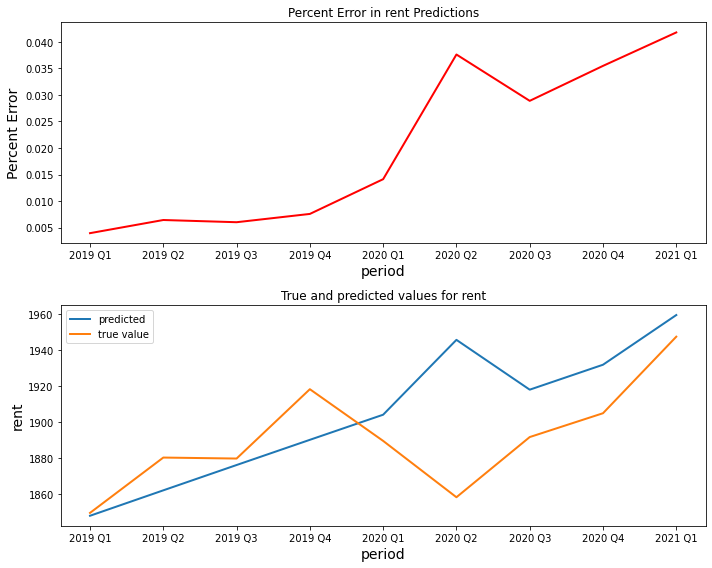

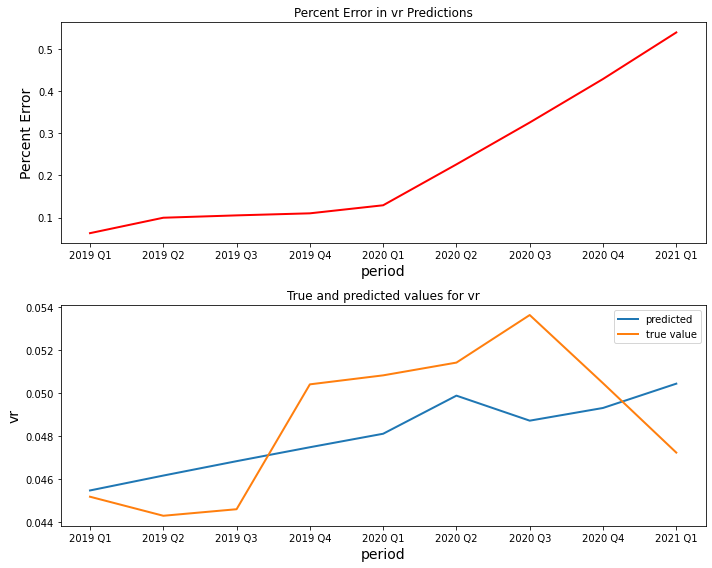

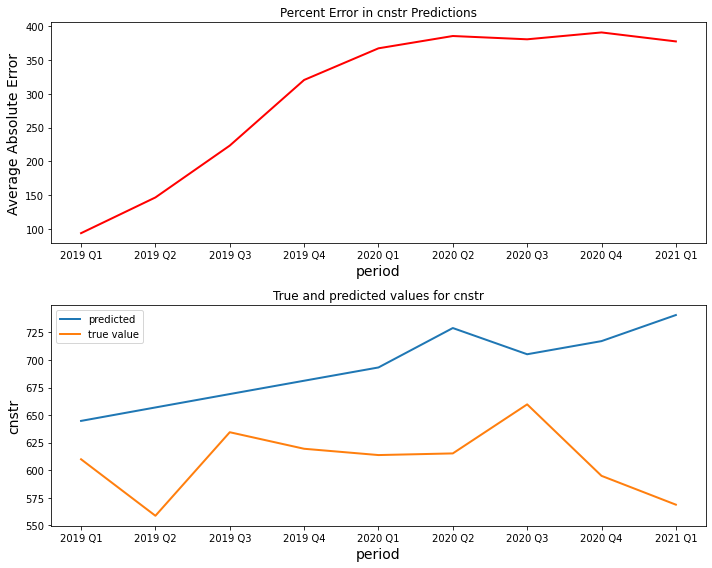

In [31]:
for key in ['rent','vr','cnstr']:
    predVal = key
    trueVal = key + "_t"
    fig, axes = plt.subplots(2,1)
    
    if key != 'cnstr':
        diffs = np.divide(toassess.loc[:,[predVal,trueVal]].diff(axis=1).iloc[:,1], toassess.loc[:,trueVal]).abs()
        axes[0].set_ylabel("Percent Error", fontsize = 14)
        
    if key == 'cnstr':
        diffs = toassess.loc[:,['cnstr','cnstr_t']].diff(axis=1).iloc[:,1].abs()
        axes[0].set_ylabel("Average Absolute Error", fontsize = 14) 
        axes[0].set_title("Absolute Error for Construction Predictions")
        
    diffs.groupby(level=0).mean().plot(figsize=(10,8), linewidth = 2, label= key,ax=axes[0],color='red')
    
    axes[0].set_xlabel("period", fontsize = 14)
    axes[0].set_title("Percent Error in %s Predictions" %key)
    #plt.savefig("/".join([data_path, 'prcError_rents.png']))

    toassess.loc[:,[predVal,trueVal]].groupby(level=0).mean().plot(ax =axes[1], linewidth=2)
    axes[1].set_ylabel("%s" %key, fontsize = 14)
    axes[1].set_xlabel('period', fontsize = 14)
    axes[1].set_title("True and predicted values for %s" %key)
    axes[1].legend(['predicted','true value'])
    plt.tight_layout()
    plt.savefig("/".join([data_path, 'pred_error_%s.png' %key]))

# Make Predictions

In [ ]:
# for convenience, I include the test-splitting here
test = df.loc[df.year>=splityear].dropna(how='any')

In [ ]:
# get a list of periods to predict
predPeriods = test.period.unique()

In [ ]:
# initiate containers
predDict = {}
dataDict = {}

In [ ]:
# initial conditions
init = test.loc[test.period == predPeriods[0],:].set_index("geography_name")
initIdx = init.index
# keep a copy of the market dummies
dums = init[['Orange County','San Diego','Ventura','Inland Empire','Q2','Q3','Q4']].reset_index(drop=True)